Like `per_iteration_analysis` and `inflecs_path_cluster_analysis` this is aimed at characterizing `confout` gro files concatenated into a `.pdb` 'trajectory'

The data will be shaped much like `per_iteration_analysis` where each simulation condition gets their own dictionary, and you can access values inside of there

In [2]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import gate_functions
import seaborn as sns
import pandas as pd

In [3]:
conditions_titles = {"BFRU": ["BFRU_out_open", "BFRU_out_occ_well1", "BFRU_out_occ_well3", "BFRU_transition_occ"], \
                     "apo":["apo_out_open", "apo_transition_occ"]}
indir = '../confout_files/FES_grids_confouts'

In [4]:
random_c = True
conditions_colors = {}
for condition, title in conditions_titles.items():
    print(condition,title, len(title))
    if 'apo' in condition:
        colormap_colors = 'Oranges_r'
    if 'BFRU' in condition:
        colormap_colors = "Greens_r"
        
    cmap_vals = plt.cm.get_cmap(colormap_colors)
    if random_c:
        np.random.seed(100)
        color_vals = cmap_vals(np.random.rand(len(title)))
        color_vals = np.sort(color_vals, axis = 0)
    else:
        color_vals = cmap_vals(np.linspace(0,1,len(title)))
    conditions_colors[condition] = color_vals

BFRU ['BFRU_out_open', 'BFRU_out_occ_well1', 'BFRU_out_occ_well3', 'BFRU_transition_occ'] 4
apo ['apo_out_open', 'apo_transition_occ'] 2


In [5]:
color_vals

array([[0.87238754, 0.31178777, 0.01997693, 1.        ],
       [0.99215686, 0.59963091, 0.30179162, 1.        ]])

In [6]:
conditions_universes = {}
for condition, titles in conditions_titles.items():
    condition_name = f"influx_{condition}_gate_CV"
    
    universe_list = []
    for title in titles:
        universe_list.append(mda.Universe(f'../confout_files/tpr_files/{condition_name}.protonly.tpr', 
                                         f'{indir}/{condition_name}/{title}/FES_grid_all.protonly.xtc'))
    
    conditions_universes[condition] = universe_list  

# Table of contents:
- EC vs IC gate
- [RMSD to original structure/ atom sim](#RMSD)
- [Sugar coordination](#sugar):
    - Contacts to sugar molecules
    - Sugar binding site differences in apo vs BFRU
- Protein contact analysis:
    - [Salt bridge contacts](#salt_br)
    - Lysine on TM1
    - ICH movements
    - Contacts to Darko CVs
- TM7b kink & TM10 kink
- Protein hydration


# EC vs IC gate

The usual...

In [7]:
conditions_gates = {}

for condition, universe_list in conditions_universes.items():
    gate_all_condition = []
    for universe in universe_list:
        EC, IC = gate_functions.make_gate_arr(md_uni=universe, 
                                              gate_EC = [(29,36), (288,294)], 
                                              gate_IC = [(135,144), (385,393)]
                                             )
        temp = np.vstack((IC,EC)).T
        gate_all_condition.append(temp)
    
    gate_all_condition = np.array(gate_all_condition)
    conditions_gates[condition] = gate_all_condition

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists
returning EC gate, IC gate dists


<ipython-input-7-0684a7c0ec51>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gate_all_condition = np.array(gate_all_condition)


returning EC gate, IC gate dists
returning EC gate, IC gate dists


BFRU
apo


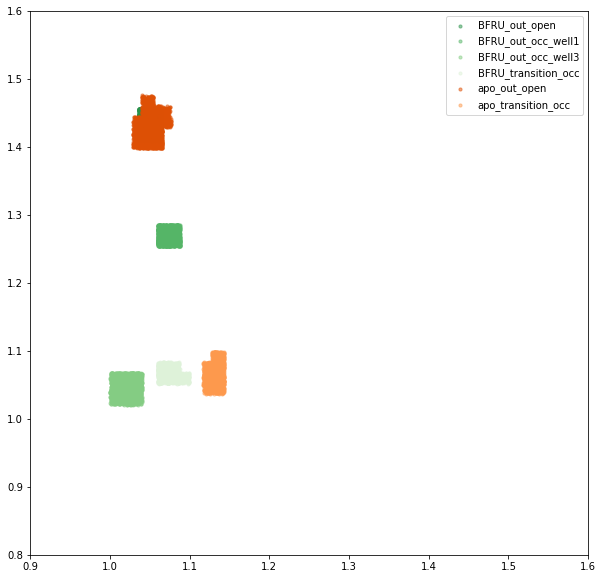

In [8]:
f = plt.figure(figsize=(10,10))
ylim = (0.8, 1.6)
xlim = (0.9, 1.6)

for condition, gate_distances in conditions_gates.items():
    print(condition)
    for n, gate_dist in enumerate(gate_distances):
        plt.scatter(gate_dist[:,0] / 10.0, gate_dist[:,1] / 10.0, 
                    label = conditions_titles[condition][n],
                    color = conditions_colors[condition][n], 
                    s = 10, alpha = 0.5)
        
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()

 <a id='RMSD'></a>


# RMSD to original structure

You can just add to `title_model` dictionary which model you would like to compare to each of your FES groups

This will add to dictionary `conditions_ref_models` which, as in `conditions_colors` and `conditions_gates` is the variable name and then a list, which is in the same order as the `titles` in `conditions_titles`

In [9]:
import MDAnalysis.analysis.rms

def calc_model_RMSD(model, traj, tpr_start):
    if tpr_start: #there is likely a better way to do this but for now, this keeps things clear what we are measuring
            RMSD = MDAnalysis.analysis.rms.RMSD(reference=model.select_atoms("protein"), \
                                        atomgroup = traj.select_atoms("protein"), \
                                        center = True, select="backbone", \
            groupselections=["backbone and (resid 0-50 or resid 264-299 or resid 117-145 or resid 363-394)",\
                             "backbone and (resid 0-204 or resid 264-454)",\
                             "resid 29-36 or resid 288-294 or resid 135-144 or resid 385-393"])  #3,4,5 on rmsd
    
    
    else:
        RMSD = MDAnalysis.analysis.rms.RMSD(reference=model.select_atoms("protein"), \
                                            atomgroup = traj.select_atoms("protein"), \
                                            center = True, select="backbone", \
                groupselections=["backbone and (resid 1-51 or resid 265-300 or resid 118-146 or resid 364-395)",\
                                 "backbone and (resid 1-205 or resid 265-455)",\
                                 "resid 30-37 or resid 289-295 or resid 136-145 or resid 386-394"])  #3,4,5 on rmsd

    RMSD.run(0)
    rmsd = RMSD.rmsd.T
    return rmsd

In [11]:
atomistic_path = '../ref_models_protonly'
conditions_ref_models = {}

title_model = {'out_open':'OUT', "out_occ_well1":"OUT-OCC", "out_occ_well3":"OCC", \
               'transition_occ':'OCC'}

for condition, titles in conditions_titles.items():
    temp = []
    for title in titles:
        t = '_'.join(title.split('_')[1:])
        temp.append(title_model[t])
        
    conditions_ref_models[condition] = temp


    

RMSD_titles = ["frame_number", \
               "time", "backbone_RMSD", "gating_helices", \
               "TM_regions", "gating_residues"]

all_dfs = []
for condition in conditions_titles:
    models = conditions_ref_models[condition]
    FES_groups = conditions_universes[condition]
    
    ## don't loop through if you only have 1 FES group to look at
    ## call tpr for model so that resid # will be same
    
    if len(FES_groups) == 1:
        model = mda.Universe('../confout_files/tpr_files/influx_apo_gate_CV.protonly.tpr'\
                             f"{atomistic_path}/{models}.start.protonly.gro")
        FES_group = FES_groups
        
    else:
        temp = []
        for model_n, FES_group in zip(models, FES_groups):
            model = mda.Universe('../confout_files/tpr_files/influx_apo_gate_CV.protonly.tpr',\
                                 f"{atomistic_path}/{model_n}.start.protonly.gro")
            rmsd = calc_model_RMSD(model, FES_group, tpr_start = True)
            temp.append(pd.DataFrame(rmsd.T, columns=RMSD_titles))
    
        test = pd.concat(temp, keys = models)
        dist_df = test.reset_index(level=[0])
        dist_df.rename(columns={'level_0':'model'}, inplace=True)

    all_dfs.append(dist_df)

result = pd.concat(all_dfs, keys = list(conditions_titles.keys()))
result = result.reset_index(level=[0])
result.rename(columns={'level_0':'condition'}, inplace=True)
result['title']=result.apply(lambda x:'%s_%s' % (x['condition'],x['model']),axis=1)

Plot these RMSDs now:
you can plot `backbone_RMSD`, `gating_helices`, `TM_regions`, `gating_residues`

swarmplot can take some time to load

(1.0, 4.0)

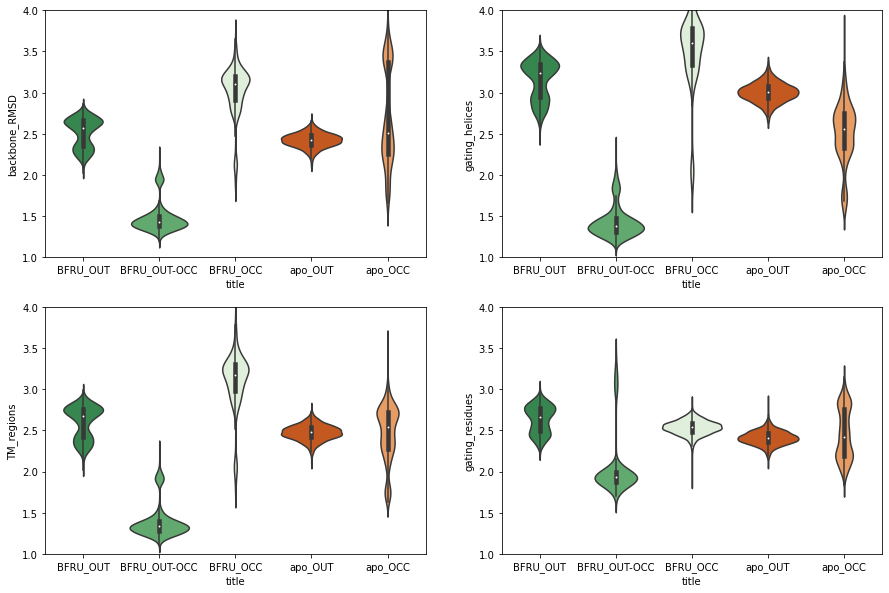

In [13]:
my_pal = {}
for condition,models in conditions_ref_models.items():
    for n, model in enumerate(models):
        sns_name = f"{condition}_{model}"
        my_pal[sns_name] = conditions_colors[condition][n]


f,axs = plt.subplots(nrows = 2, ncols=2, figsize = (15,10))  
axs = np.ravel(axs)

lim = (1,4)
vm = sns.violinplot(ax = axs[0], x='title', y = 'backbone_RMSD', data = result, palette=my_pal)
vm.set_ylim(lim)
vm = sns.violinplot(ax = axs[1], x='title', y = 'gating_helices', data = result, palette=my_pal)
vm.set_ylim(lim)
vm = sns.violinplot(ax = axs[2], x='title', y = 'TM_regions', data = result, palette=my_pal)
vm.set_ylim(lim)
vm = sns.violinplot(ax = axs[3], x='title', y = 'gating_residues', data = result, palette=my_pal)
vm.set_ylim(lim)

#sns.swarmplot(x='title', y = 'backbone_RMSD', data = result, palette=my_pal, size=2)

 <a id='sugar'></a>


# sugar coordination


<a id='salt_br'></a>


# salt bridge
I check this to be sure that the protein is in a state that I think is reasonable and that things that are not the gate spaces are "well-behaved"

In [14]:
salt_bridges = [('GLU:145', 'ARG:91'), ('GLU:145', 'ARG:401'), \
                ('GLU:394', 'ARG:152'), ('GLU:394', 'ARG:334'), \
                ('GLU:330', 'ARG:334')]

In [15]:
import MDAnalysis.analysis.distances as d

def get_salt_bridge(md_uni, salt_bridge_list, paper_num = None):
    print ('removing one from each resid, as tpr file being used')
    bridges_all = np.zeros((len(salt_bridge_list), len(md_uni.trajectory)))
    labels = []
    for n, SB in enumerate(salt_bridge_list):
        c1 = md_uni.select_atoms(f"resname {SB[0].split(':')[0]} and resid {int(SB[0].split(':')[1]) - 1}")
        c2 = md_uni.select_atoms(f"resname {SB[1].split(':')[0]} and resid {int(SB[1].split(':')[1]) - 1}")
    
        sb_dists = []
        for ts in md_uni.trajectory:
            sb_dists.append(np.min(d.distance_array(c1.positions, c2.positions)))
        
        bridges_all[n] = sb_dists
        if not paper_num:
            labels.append(f'{SB[0]} - {SB[1]}')
        else:
            print('Returning label as paper numbering (+6)')
            labels.append(f"{SB[0].split(':')[0]}:{int(SB[0].split(':')[1]) + 6} - {SB[1].split(':')[0]}:{int(SB[1].split(':')[1]) + 6}")
    return bridges_all, labels

In [16]:
bridges_df = []
for condition, universes in conditions_universes.items():
    df_temp = []
    titles_temp = []
    for n,universe in enumerate(universes):
        temp, labels = get_salt_bridge(universe, salt_bridges, paper_num = True)
        temp = pd.DataFrame(temp.T, columns = labels)
        df_temp.append(temp)
        titles_temp.append(conditions_titles[condition][n])
        
        ## add dfs and join them
        temp = pd.concat(df_temp, keys = titles_temp)
        temp = temp.reset_index(level=[0])
        temp.rename(columns={'level_0':'condition'}, inplace=True)
    
    bridges_df.append(temp) 
bridges_df = pd.concat(bridges_df, keys = list(conditions_titles.keys()))
bridges_df = bridges_df.reset_index(level=[0])
bridges_df.rename(columns={'level_0':'condition2'}, inplace=True)
bridges_df['Title']=bridges_df.apply(lambda x:'%s_%s' % (x['condition'],x['condition2']),axis=1)

removing one from each resid, as tpr file being used


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:675: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
removing one from each resid, as tpr file being used
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
removing one from each resid, as tpr file being used
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
removing one from each resid, as tpr file being used
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
Returning label as paper numbering (+6)
removing one from each resid, as tpr file

In [17]:
split_dfs = []
for column in bridges_df.columns:
    if ':' in column:
        temp = bridges_df.loc[:,[column, 'Title']]
        temp.rename(columns={column:'distance'}, inplace=True)
        temp = temp.assign(bridge_name = column)
        split_dfs.append(temp)

bridges_df_reshaped = pd.concat(split_dfs)

<AxesSubplot:xlabel='Title', ylabel='distance'>

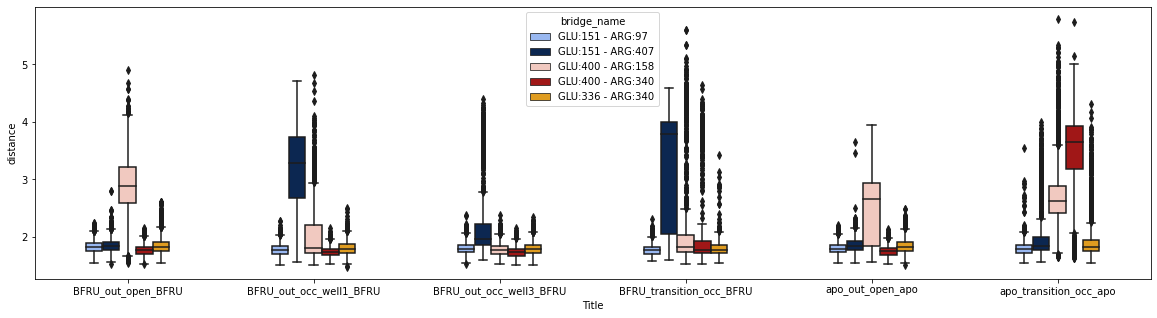

In [18]:
f = plt.figure(figsize = (20,5))
my_pal = {'GLU:151 - ARG:97':'#8BB4FF', 'GLU:151 - ARG:407':'#00245D', \
          'GLU:400 - ARG:158':'#F9C4B8', 'GLU:400 - ARG:340':'#B70000', 'GLU:336 - ARG:340':'orange'}
sns.boxplot(x='Title', y = 'distance', hue = 'bridge_name', data= bridges_df_reshaped, width=0.45, palette=my_pal)